In [1]:
#in this notebook we will pass in the specimen cell images into our models.
#then based off the predictions, we will compute the nuclear area, cyto area and nc ratio
import cv2
import numpy as np
import torch
from functools import reduce
from torchvision import transforms
import pandas as pd

# 1. Load pickle
sps = pd.read_pickle("specimens_toy_data.pkl")

df=pd.concat([sps[k]["metadata"].assign(class_=lambda x: k) for k in sps])
df["class_"]=pd.Categorical(df["class_"],["neg","aty","sus","pos"])

# 2. Resize all images to 256x256
resize = lambda x: cv2.resize(x, (256, 256), interpolation=cv2.INTER_CUBIC)
all_images = reduce(lambda x, y: x + y, [list(map(resize, sps[k]["imgs"])) for k in sps])  # List of resized numpy arrays

# 3. Convert to float tensor and normalize to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to (C, H, W) and scales to [0,1]
])

X_input = torch.stack([transform(img) for img in all_images])  # Shape: (N, 3, 256, 256)

print("Final input shape:", X_input.shape)



Final input shape: torch.Size([100, 3, 256, 256])


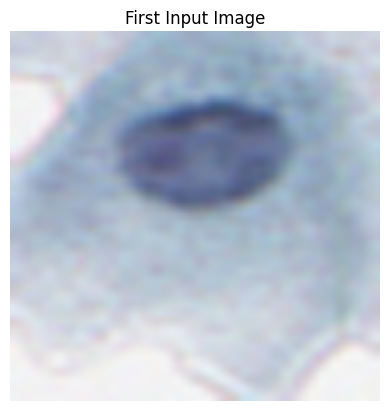

In [2]:
import matplotlib.pyplot as plt

# Get the first image tensor and convert to numpy
img = X_input[0].cpu().numpy()  # (3, 256, 256)

# Permute to (256, 256, 3) for imshow
img = np.transpose(img, (1, 2, 0))

# Plot
plt.imshow(img)
plt.title("First Input Image")
plt.axis("off")
plt.show()


In [ ]:
from semseg_functions import make_predictions
from sklearn.metrics import classification_report
import time

begin_time=time.time()
y_val_pred=make_predictions(X_input,model=None)
y_val_pred_lbls=y_val_pred.argmax(1)
end_time=time.time()
total_time=end_time-begin_time
#print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))
print(f"Time taken for predictions: {total_time:.2f} seconds")

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend

Loading model from: ./seg_models/bestunet_model.pkl
Time taken for predictions: 6.30 seconds


In [4]:
def calc_areas(y_val_pred_lbls):
    nucleus_area_pred = (y_val_pred_lbls == 2).sum(axis=(1, 2))  # Sum over height and width
    cyto_area_pred = (y_val_pred_lbls == 1).sum(axis=(1, 2))  # Sum over height and width
    nc_ratio_pred = nucleus_area_pred / (nucleus_area_pred + cyto_area_pred)  # Avoid division by zero
    return nucleus_area_pred, cyto_area_pred, nc_ratio_pred

In [5]:
df.head()

,aty,nc_ratio,nuclear_area,cyto_area,class_
0,0.057022,0.141928,7221.0,43657.0,neg
1,0.037513,0.175625,7597.0,35660.0,neg
2,0.056971,0.150782,7442.0,41914.0,neg
3,0.077020,0.182437,8177.0,36644.0,neg
4,0.111039,0.183712,8696.0,38639.0,neg


In [6]:
#using predicted labels, compute nuclear area, cyto area and nc ratio
#compare with ground truth
